## Step 1
### About the Dataset

Polaris ([polarishub.io](https://polarishub.io/datasets/asap-discovery/antiviral-potency-2025-unblinded)) is an open-source platform that provides high-quality datasets for machine learning in drug discovery.

The chosen dataset ([source](https://asapdiscovery.org/pipeline/)) contains 1,328 pIC50 values against both the MERS-CoV Mpro target and the SARS-CoV-2 Mpro target. I've chosen this as it is intended to reflect a realistic dataset used in drug discovery settings, unlike other sources such as the [MoleculeNet](https://moleculenet.org/) datasets, which have been criticised for their flaws (see [this blogpost](https://practicalcheminformatics.blogspot.com/2023/08/we-need-better-benchmarks-for-machine.html) by Pat Walters).

This dataset was used in a blind challenge, with the dataset split into training and test, which is labelled in the 'set' column. Here, I will hold out the test set entirely until after completing my cross-validation (CV) procedure. i.e. I will conduct my training and CV procedure on the datapoints labelled 'train', then will test the performance of the model on the 'test' datapoints.

Some issues have been highlighted with this dataset. In particular, some enantiomers were given the same SMILES strings, so even if they had different bioactivities, a machine learning model wouldn't be able to distinguish between the two. As such, I will filter out those cases when testing the model, as was done for the challenge.

In [1]:
from data.dataset import dataset, dataset_df

dataset_df

/Users/femisegvn/Coding/miniconda3/envs/antiviral-pot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,CXSMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
0,COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...,ASAP-0000141,Train,4.19,NaN
1,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000142,Train,4.92,5.29
2,CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C...,ASAP-0000143,Train,4.73,NaN
3,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000144,Train,4.90,6.11
4,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000145,Train,4.81,5.62
...,...,...,...,...,...
1323,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032561,Test,4.54,4.20
1324,O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...,ASAP-0032562,Test,4.42,NaN
1325,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]2CCCC[C@@H]...,ASAP-0032572,Test,4.84,5.18
1326,COC1=CC=CC=C1[C@H]1C[C@H](C)CCN1C(=O)CC1=CN=CC...,ASAP-0032604,Test,5.53,5.59


## Step 2

### Data Preprocessing

As mentioned in the previous step, indistinct enantiomers need to be removed. Polaris noted entries `1036, 1039, 1219, 1225, 1306`, but I will verify that these are the only cases of such. Multiple SMILES strings can be used to represent the same molecule so I will canonicalise the smiles by transforming them into an `rdkit.mol` object and transforming that back into a SMILES string. I will also be checking for other duplicate entries.

My Cleaning process is as follows:
1. remove entries `1036, 1039, 1219, 1225, 1306`
2. canonicalise CXSMILES
3. Check for duplicates in training and test data 
    - if duplicates occur within the training set, merge them
    - if duplicates occur in the test set ???
    - if a duplicate has one in the the training set and one in the test set, remove this entry entirely -- entries
    shouldn't be present in both the training and test set.

In [2]:
# First of all, I will remove the datapoints that Polaris as recommended to be removed from the dataset
dataset_df = dataset_df.drop([1036,1039,1219,1225,1306], axis=0)

In [3]:
# Here we canonicalise the smiles, ensuring a consistent systematic representation across all molecules
from utils import canonicalise_smiles
dataset_df.CXSMILES = canonicalise_smiles(dataset_df.CXSMILES)

In [4]:
# Checking for duplicates we see 172 rows of multiple instances of a CXSMILES
smiles = dataset_df.CXSMILES
duplicates = dataset_df[smiles.duplicated(keep=False)]
duplicates

,CXSMILES,Molecule Name,Set,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
37,C[C@H]1CC[C@@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C...,ASAP-0000180,Train,4.57,4.65
38,C[C@H]1CC[C@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C1...,ASAP-0000181,Train,4.69,4.37
39,C[C@H]1CC[C@@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C...,ASAP-0000182,Train,4.34,4.21
40,C[C@H]1CC[C@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2C1...,ASAP-0000183,Train,4.76,NaN
69,CO[C@H]1CC[C@@H]2C(=O)N(c3cncc4ccccc34)C(=O)N2...,ASAP-0000228,Train,4.23,4.22
...,...,...,...,...,...
1322,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1 |o...,ASAP-0032560,Test,4.33,4.02
1323,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1 |o...,ASAP-0032561,Test,4.54,4.20
1324,O=C(Cc1cncc2ccccc12)N1CCCC[C@H]1[C@H]1CCCO1 |o...,ASAP-0032562,Test,4.42,NaN
1326,COc1ccccc1[C@H]1C[C@H](C)CCN1C(=O)Cc1cncc2cccc...,ASAP-0032604,Test,5.53,5.59


In [5]:
# Check the dataset to see if any SMILES in the training set are repeated in the test set
from utils import train_test_overlap
overlap = train_test_overlap(dataset_df)
overlap


set()

In [6]:
# Merge duplicate entries finding the mean of their pIC50s
from utils import merge_duplicates

dataset_df_clean = merge_duplicates(dataset_df)
dataset_df_clean

,CXSMILES,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro),Molecule Name,Set
0,C#CC(=O)N1CCN(Cc2cccc(Cl)c2)[C@H]2CS(=O)(=O)C[...,4.600,5.32,ASAP-0016438,Train
1,C#CC1(C)CCN(C(=O)Cc2cncc3ccccc23)CC1,4.990,5.33,ASAP-0031776,Train
2,C#Cc1ccc(NC(=O)C=C)cc1N(Cc1cccc(Cl)c1)C(=O)Cc1...,4.460,NaN,ASAP-0013314,Train
3,C#Cc1ccc([C@H]2CCCCN2C(=O)Cc2cncc3ccccc23)cc1 ...,5.660,4.85,ASAP-0032181,Test
4,C#Cc1ccc2c(c1)[C@H](C(=O)Nc1cncc3ccccc13)CN(C)...,4.425,4.66,ASAP-0008477,Train
...,...,...,...,...,...
1235,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,6.630,7.13,ASAP-0015916,Train
1236,O=C1c2ccc(Cl)cc2[C@@]2(CN1Cc1nnco1)C(=O)N(c1cn...,6.810,7.30,ASAP-0017058,Test
1237,O=[S@](Cc1cccc(Nc2ncnc3[nH]ccc23)c1)c1ccccc1 |...,4.940,NaN,ASAP-0000269,Train
1238,O=c1c(-c2cccc(Cl)c2)cnc(S)n1-c1cncc2ccccc12,5.040,6.86,ASAP-0000171,Train


COC[C@]1(C)C(=O)N(c2cncc3ccccc23)C(=O)N1C |&1:3|


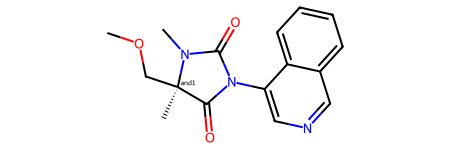

COC[C@]1(C)C(=O)N(c2cncc3ccccc23)C(=O)N1C |&1:3|


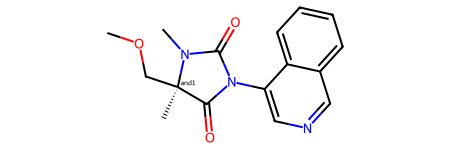

COC[C@]1(C)C(=O)N(c2cncc3ccccc23)C(=O)N1C


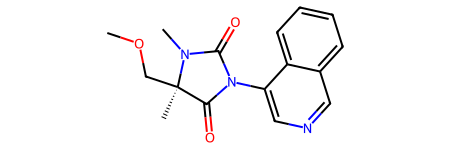

In [7]:
from rdkit import Chem
s = dataset_df.CXSMILES[0]
print(s)
mol = Chem.MolFromSmiles(s)
display(mol)

s = Chem.MolToCXSmiles(mol)
print(s)
mol=Chem.MolFromSmiles(s)
display(mol)

s = Chem.MolToSmiles(mol)
print(s)
mol=Chem.MolFromSmiles(s)
display(mol)



#### Food for thought
Canonicalising these CXSMILES made me think of a couple things. 

1. It's interesting that aromatic systems in (CX)SMILES representation can be represented as a kekule structure e.g. in `(C2=CN=CC3=CC=CC=C23)`, but also as a delocalised system e.g. `(c2cncc3ccccc23)`.

2. `rdkit` appears to eliminate the extra information provided by a *CX*SMILES when converting from the `rdkit.mol` object into a SMILES via `Chem.MolToSmiles()`. How much does this extra information provided by CXSMILES matter? It *can* be kept by using `Chem.MoltoCXSmiles()`. How can we use the extra information from CXSmiles to build a better model?

## Step 3

### Dataset Exploration

## Step 4

### Model Training

## Step 5

### Performance Testing

## Step 6

### Optimisation

Improving performance by means of feature selection/engineering and hyperparameter optimisation